<a href="https://colab.research.google.com/github/MaggieLieu/MLiS_examples/blob/master/Graph_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import random

# Graph CNN

Let's consider the Zachary karate club data set. Here two karate teachers had a conflict and tried recruiting members in each others group. Two groups will be formed at the end, but can we predict what those groups will be?

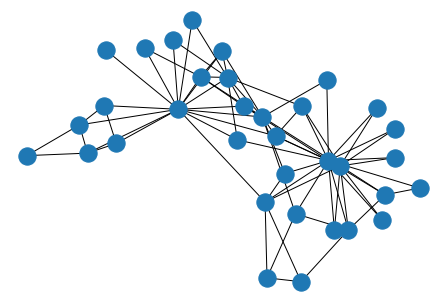

In [109]:
G = nx.karate_club_graph() # import zachary karate club data
nx.draw(G) #plot spatial network

Now let's plot the network again. Note the same graph can look different because graphs are not spatially fixed. They can move around. 

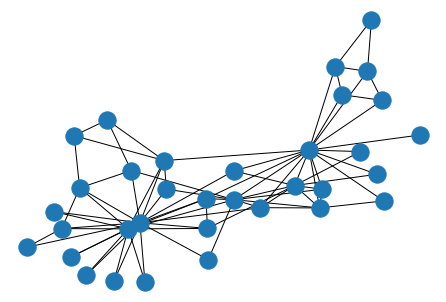

In [110]:
nx.draw(G) #plot spatial network again.

Now let's plot the spectral graph

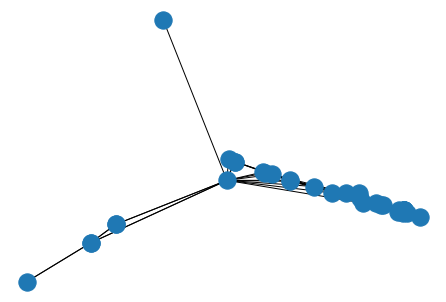

In [111]:
nx.draw_spectral(G) #plot spectral graph

The spectral graph does not change.

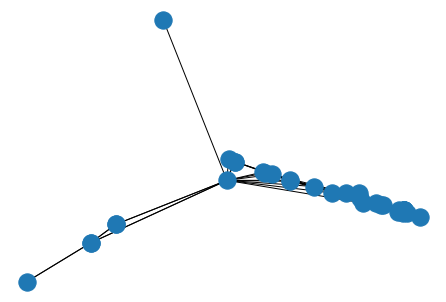

In [112]:
nx.draw_spectral(G) #plot spectral graph again

Let's get some details about this social network. 

In [113]:
print('Nodes: \n', G.nodes) #print nodes
print('Degrees: \n', G.degree()) #print number of degrees of each node (connections)
print('Edges: \n', G.edges) # print the connections
print('Node 0: \n', G.nodes[0]) # print data on node 0
print('Node 20: \n', G.nodes[20]) # print data on node 20

Nodes: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Degrees: 
 [(0, 16), (1, 9), (2, 10), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (9, 2), (10, 3), (11, 1), (12, 2), (13, 5), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 3), (20, 2), (21, 2), (22, 2), (23, 5), (24, 3), (25, 3), (26, 2), (27, 4), (28, 3), (29, 4), (30, 4), (31, 6), (32, 12), (33, 17)]
Edges: 
 [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 

We can see there are 34 nodes and each have a number of connections with other nodes. Each node is assigned to a Karate club, 'Mr. Hi' or 'Officer'. Now let's get the adjacency matrix, which tells us which nodes are connected, note that the adjacency matrix is symmetric.



shape:  (34, 34)


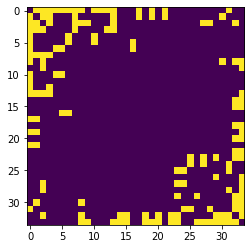

In [114]:
A = nx.to_numpy_matrix(G) #get adjacency matrix
print('shape: ', np.shape(A));
plt.imshow(A);

We can plot the graph with labels to see what nodes correspond to which rows and columns, and additionally colour the nodes according to the club. 

In [0]:
(col1, col2) = ('black','orange')

node_color = [col1] * G.number_of_nodes()

for n in G.nodes():
    if G.nodes[n]['club'] == 'Officer':
      node_color[n] = col2

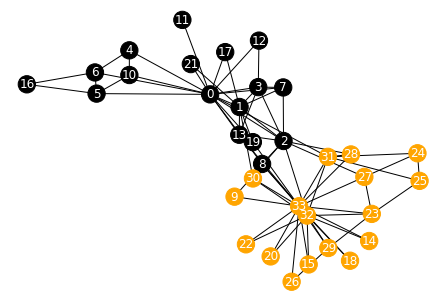

In [116]:
nx.draw(G, node_color=node_color, with_labels=1, font_color='white')

We need to add self connections to the adjacency matrix. So let's make an identity matrix with the same size and add it to the adjacency matrix. 

shape:  (34, 34)


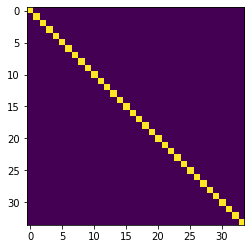

In [117]:
I = np.eye(G.number_of_nodes())
print('shape: ', np.shape(I));
plt.imshow(I);

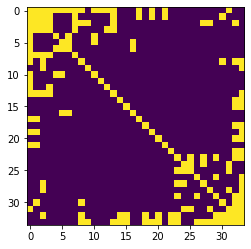

In [118]:
A_hat = A+I
plt.imshow(A_hat);

We need to normalise the matrix, and this is done by multiplying with the inverse of the degree matrix. So let's define the degree matrix.

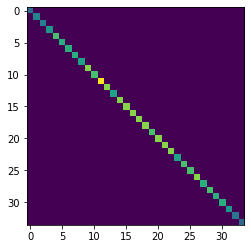

In [119]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_inv = np.diag(D_hat**-0.5)

plt.imshow(D_inv);

Now lets make some weights that will eventually be the trainable parameters

In [0]:
W_1 = np.random.normal(loc=0, size=(G.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

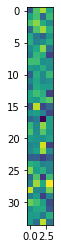

In [121]:
plt.imshow(W_1);

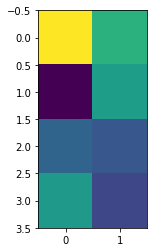

In [122]:
plt.imshow(W_2);

This is what a typical GCN network would then look like

In [0]:
def relu(x):
   return np.maximum(x, 0)

def gcn_layer(A_hat, D_inv, X, W):
    A_hat = D_inv * A_hat * D_inv
    return relu(np.dot(np.dot(A_hat, X),W))

L1 = gcn_layer(A_hat, D_inv, I, W_1) #layer1
L2 = gcn_layer(A_hat, D_inv, L1, W_2) #layer2

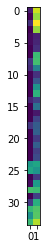

In [124]:
plt.imshow(L2);

Even without any training we can get some useful features extracted from last layer of the network. So lets visualise them in position space.

In [0]:
feature_representations = {
    node: np.array(L2)[node] 
    for node in G.nodes()}

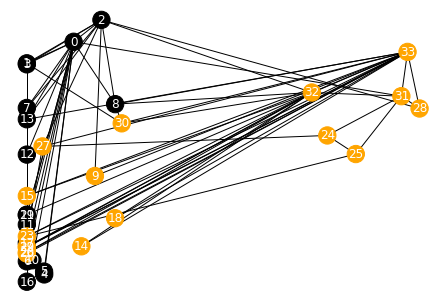

In [126]:
G.add_nodes_from(feature_representations.keys())
for n, p in feature_representations.items():
   G.nodes[n]['pos'] = p

nx.draw(G,pos=feature_representations, with_labels=True, node_color=node_color, font_color='white')

# Node importance

There are 3 things that we may be interested in. 

1. Degree of centrality, is a measure of the fraction of nodes each node is connected to. This tells us how connected nodes are. 
$$ C_{degree} = \frac{D}{N-1}$$
Where $D$ is the degree, and $N$ is the total number of nodes.

2. Closeness centrality, is a measure of how close nodes are to each node. It tells us the closest nodes. 
$$ C_{closeness} = \frac{N-1}{\sum_i^{N-1} d^i_{min}}$$
where $d^i_{min}$ is the shortest path to node $i$.

3. Betweeness centrality, is a measure of the weakest links in the network. This can be important for example in the case of the Karate club for example, because every link is connected, eventually, they could all be converted to 1 club but if the coaches could choose 1 link to break with the biggest influence to obtain the largest impact.
$$ C_{betweeness} = \sum^{N-1}_{i} \frac{d_{\nu, min}}{d^i_{min}} $$
where $d_{\nu,min}$ are the number of shortest paths that pass through node $\nu$.


In [127]:
print('max degree centrality: ', max([nx.degree_centrality(G)[i] for i in np.arange(G.number_of_nodes())]))
print('min closeness centrality: ',min([nx.closeness_centrality(G)[i] for i in np.arange(G.number_of_nodes())]))
print('max degree centrality: ', max([nx.betweenness_centrality(G)[i] for i in np.arange(G.number_of_nodes())]))

max degree centrality:  0.5151515151515151
min closeness centrality:  0.28448275862068967
max degree centrality:  0.43763528138528146


Sometimes it's better to visualise connections with a circular graph plot. With it we can see 0 and 33 are the most well connected nodes.

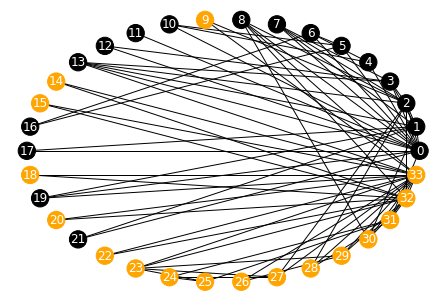

In [128]:
nx.draw_circular(G, with_labels=True, node_color=node_color, font_color='white')

In [178]:
print(G.nodes()[0])
print(G.nodes()[33])

{'club': 'Mr. Hi', 'pos': array([0.06367181, 0.69972192])}
{'club': 'Officer', 'pos': array([0.51823218, 0.67228122])}


In [0]:
network = G.edges #edges
attributes = [G.nodes[n]['club'] for n in np.arange(G.number_of_nodes())] #labels

In [0]:
His = np.where(np.array(attributes) == 'Mr. Hi')[0]
Officers = np.where(np.array(attributes) == 'Officer')[0]

We want to build a training sample using only the club leaders and they are most likely to be the most connected nodes. 



In [0]:
# training_data, get indices of nodes for training
X_train = np.array([0,33])
#get labels
y_train = (np.array(attributes)[X_train] == 'Mr. Hi').astype('uint8') #returns 1 if Mr. Hi else 0


In [260]:
X_train

array([ 0, 33])

In [261]:
y_train

array([1, 0], dtype=uint8)

# Build the model
First we've got to initialise the variables. 

In [0]:
with tf.GradientTape() as tape:
  tape.reset()

In [0]:
def inititialise_variables(input_sz, output_sz):
# initialise variables 
  W1 = tf.Variable(tf.random.uniform([input_sz,4], minval=-1, maxval=1, dtype=tf.float64 ), name='W1')
  W2 = tf.Variable(tf.random.uniform([4,2], minval=-1, maxval=1, dtype=tf.float64 ), name='W2')
  W3 = tf.Variable(tf.random.uniform([2,1],  minval=-1, maxval=1,dtype=tf.float64 ), name='W3')
  b3 = tf.Variable(tf.random.uniform([1], minval=-1, maxval=1, dtype=tf.float64 ), name='b3')
  return(W1,W2,W3,b3)


In [0]:
def gcn_layer(A_hat, D_inv, X, W):
  A_hatnorm = D_inv * A_hat * D_inv
  AX = tf.tensordot(A_hatnorm, X, axes=1)
  out = tf.tensordot(AX, W, axes=1)
  return out


#Define model
def model(A, X, L0):
  nx, ny = A.get_shape()
  I = tf.eye(nx, dtype=tf.float64)
  A_hat = A + I
  D_hat = tf.math.pow(tf.math.reduce_sum(A_hat,axis=0),-0.5)
  D_inv = I * D_hat # diagonal matrix
  
  L1 = gcn_layer(A_hat, D_inv, L0, W1) #layer1
  aL1 = tf.nn.tanh(L1)
  L2 = gcn_layer(A_hat, D_inv, aL1, W2) #layer2
  aL2 = tf.nn.tanh(L2)

  FCL = tf.reshape(tf.tensordot(aL2, W3, axes=1),[-1]) + tf.broadcast_to(b3, [nx]) #fully connected layer 
  #aFCL = tf.nn.sigmoid(FCL) #sigmoid activation, dont include as we use with_logits loss.
  output = tf.gather(FCL, X) #only return the training values

  return(output)

# Train model

In [0]:
LR = 0.01 #learning rate
optimizer = tf.optimizers.SGD(learning_rate=LR, momentum=1) #SGD optimiser
#bce = tf.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE) 

def train_step( model, A, L0, X , y ):
    with tf.GradientTape() as tape:
        pred = model(A, X, L0)
        current_loss = tf.nn.sigmoid_cross_entropy_with_logits(y, pred)  #bce(y, pred) 
    grads = tape.gradient( current_loss , [W1,W2,W3,b3] )
    optimizer.apply_gradients( zip( grads , [W1,W2,W3,b3]) )

    return(current_loss)

In [354]:
nepoch = 800

input_sz = 2 #input size needs to be the same as the number of features (L0 which we define later)
output_sz = G.number_of_nodes() #output size needs to be the same as the number of nodes
W1,W2,W3, b3 = inititialise_variables(input_sz,output_sz)

A = nx.to_numpy_matrix(G) #get adjacency matrix
A = tf.constant(A, dtype=tf.float64)

# We could use the identity matrix as the feature matrix.
X_1 = tf.eye(output_sz, dtype=tf.float64) 

#or instead of identity matrix, we can use the features of shortest path.
X_2 = np.zeros((A.shape[0], 2))
node_officer = nx.shortest_path_length(G, target=33)
node_hi = nx.shortest_path_length(G, target=0)

for node in G.nodes():
    X_2[node][1] = node_officer[node]
    X_2[node][0] = node_hi[node]

#input feature matrix, have a play with this. It can be the identity matrix or shortest path, or combination of both. 
L0 = X_2 #tf.constant(np.concatenate((X_1,X_2),axis=1), dtype=tf.float64) 
tloss = [] 

for epoch in range(nepoch):
    for i, x in enumerate(X_train): #run training
      loss = train_step( model , A, L0,x, tf.constant(y_train[i], dtype=tf.float64))
    tloss.append(loss)
    if epoch % 10 is 0: 
      tf.print('epoch: ',epoch, ', loss:', loss)       

epoch:  0 , loss: 1.1161530086212048
epoch:  10 , loss: 0.91170880524924081
epoch:  20 , loss: 0.5619037753124454
epoch:  30 , loss: 0.40048868640099078
epoch:  40 , loss: 0.47232858396374866
epoch:  50 , loss: 0.77123565980213615
epoch:  60 , loss: 1.0816394999195276
epoch:  70 , loss: 1.0289836568937092
epoch:  80 , loss: 0.68185624915137932
epoch:  90 , loss: 0.43154459782563642
epoch:  100 , loss: 0.4144012261608877
epoch:  110 , loss: 0.62974927688926008
epoch:  120 , loss: 0.980366647180322
epoch:  130 , loss: 1.08741958286332
epoch:  140 , loss: 0.80728870237295147
epoch:  150 , loss: 0.4845550194757467
epoch:  160 , loss: 0.37617991121366073
epoch:  170 , loss: 0.48739005224212195
epoch:  180 , loss: 0.783527625083898
epoch:  190 , loss: 0.97889535575271591
epoch:  200 , loss: 0.78137276800247613
epoch:  210 , loss: 0.41262822830212964
epoch:  220 , loss: 0.20332781100350031
epoch:  230 , loss: 0.13196337930909682
epoch:  240 , loss: 0.1001075986644394
epoch:  250 , loss: 0.062

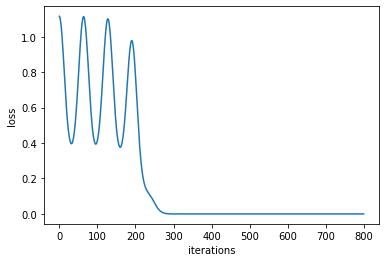

In [355]:
plt.plot(np.arange(nepoch),tloss);
plt.xlabel('iterations');
plt.ylabel('loss');

# Apply trained model to all data 

In [0]:
X_test = np.arange(0,34)
y_test = (np.array(attributes) == 'Mr. Hi').astype('uint8') #true labels

test_pred = np.round(tf.nn.sigmoid(model(A, X_test, L0).numpy())).astype('uint8') #model predictions

In [357]:
test_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [358]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

Get colours of new predictions in black and orange, and colour the training nodes as grey

In [0]:
(col1, col2, col3) = ('black','orange', 'grey')

pred_color = [col1] * G.number_of_nodes()

for n in np.arange(G.number_of_nodes()):
    if test_pred[n] == 0:
      pred_color[n] = col2

for n in X_train:
  pred_color[n] = col3
    

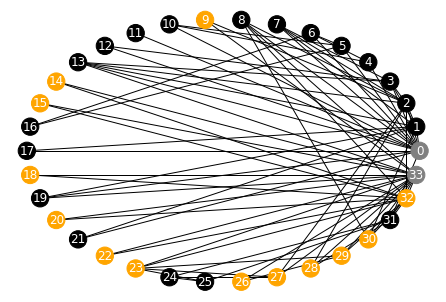

In [360]:
nx.draw_circular(G, node_color=pred_color, with_labels=True, font_color='white')

compare to the true labels

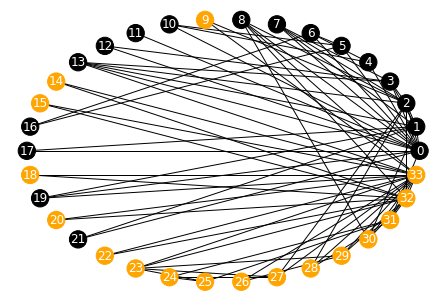

In [361]:
nx.draw_circular(G, node_color=node_color, with_labels=True, font_color='white')

# Metrics 
Let's see more quantitatively how we performed

In [362]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        17
           1       0.85      1.00      0.92        17

    accuracy                           0.91        34
   macro avg       0.93      0.91      0.91        34
weighted avg       0.92      0.91      0.91        34

